In [501]:
import pandas as pd, numpy as np
np.set_printoptions(suppress=True)# 关掉科学计数法
import glob
import os
import csv
# 一次性merge多个pct_chg
from functools import reduce
from datetime import datetime, timedelta

# import yfinance as yf
import tushare as ts
import time, urllib
ts.set_token('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)

from plotly.graph_objs import Scatter,Layout
import plotly
import plotly.offline as py
import numpy as np
import plotly.graph_objs as go

#setting offilne
plotly.offline.init_notebook_mode(connected=True)

1. Download ETFs' most recent data
2. Use market cap to filter out the largest ETFs by market cap
3. Use correlation to filter out the most uncorrelated ETFs
4. Generate selected 40 tickers as pool
5. Calculate the positions' weights

# Parameters and Settings

In [502]:
# Mannually check our current position holdings for potential exit signals:
cur_positions = [
    '159916',
#     '159918',
#     '159932',
    '159933',
#     '159938',
    '159951',
    '510090',
    '510110',
    '510270',
    '510580',
#     '511030',
#     '512010',
#     '512290',
#     '512560',
    '518880'
]
len(cur_positions)

8

In [503]:
date = [
    "2020-01-02",
    "2020-01-03",
    "2020-01-06",
    "2020-01-07",
    "2020-01-08",
    "2020-01-09",
    "2020-01-10",
    "2020-01-13",
    "2020-01-14",
    "2020-01-15",
    "2020-01-16",
    "2020-01-17",
    "2020-01-20",
    "2020-01-21",
    "2020-01-22",
    "2020-01-23",
    "2020-02-03",
    "2020-02-04",
    "2020-02-05",
    "2020-02-06",
    "2020-02-07",
    "2020-02-10",
    "2020-02-11",
    "2020-02-12",
    "2020-02-13",
    "2020-02-14",
    "2020-02-17",
    "2020-02-18",
    "2020-02-19",
    "2020-02-20",
    "2020-02-21",
    "2020-02-24",
    "2020-02-25",
    "2020-02-26",
    "2020-02-27",
    "2020-02-28"
]
sbtv1 = [0+1,#1/2
        0+1,
        0+1,
        0+1,
        -0.005/100+1,
        -0.001/100+1,
        0.01/100+1,
        0.01/100+1,
        0.03/100+1,
        0.02/100+1,
        -0.03/100+1,
        0.06/100+1,
        0.07/100+1,
        0.13/100+1,
        0.0795/100+1,
        0.2/100+1,
        0.68136/100+1,
         710/200000+1,#2/4
         824.42/200000+1,#2/5
         654.42/200000+1,#2/6
         745.42/200000+1,#2/7
         833/200000+1,#2/8
         933/200000+1,#2/11
         911/200000+1,
         676.53/200000+1,
         882.52/200000+1,
         1813.76/200000+1,
         2210.96/200000+1,
         1947.66/200000+1,
         2553.70/200000+1,
         2881.31/200000+1, #2020-02-21
         3423.72/200000+1,
         3239.46/200000+1,
         2397.44/200000+1,
         2379.78/200000+1,
         1123.98/200000+1
        ]

# General Import of ETF Data

In [721]:
def handle_data_files_return_tickers(file_path):
    ch_etfs_df = pd.read_csv(file_path)
#     ch_etfs_df.dropna(inplace = True)
    try:
        ch_etfs_df['基金规模\n[单位] 元'] = ch_etfs_df['基金规模\n[单位] 元'].apply(lambda x: float(x.replace(",","")))
        ch_etfs_df['机构投资者持有份额\n[报告期] 2019中报\n[单位] 份'] = ch_etfs_df['机构投资者持有份额\n[报告期] 2019中报\n[单位] 份'].apply(lambda x: float(x.replace(",","")))
        ch_etfs_df.sort_values("基金规模\n[单位] 元", ascending=False, inplace =True)
    except Exception as e:
        print(e)
    ch_etfs = ch_etfs_df.copy()
    ch_etfs['code'] =ch_etfs['证券代码'].apply(lambda x: str(x)[:6])
    ch_etfs_ticker = list(ch_etfs['code'].unique())
    return ch_etfs_ticker

# def select_df_from_db_by_tickers(path, ticker_list):
#     # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    
#     csv_path = path+"*.csv"
#     files = glob.glob(csv_path)
    
#     tickers_data = []
#     if len(ticker_list)!=1:
#         for ticker in ticker_list:
#             print("Reading: ", ticker)
#             df = pd.read_csv(path+ticker+".csv")
#             tickers_data.append(df)
#         tickers_data_concated = pd.concat(tickers_data)
#         tickers_data_concated.reset_index(inplace=True)
#         del tickers_data_concated['index']
#     else:
#         df = pd.read_csv(path+ticker_list[0]+".csv")
#         tickers_data_concated = df
#     return tickers_data_concated

def get_mkt_data_df(path, ticker_list, date_col):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    csv_path = path+"*.csv"
    files = glob.glob(csv_path)
    ticker_df_list = []
    for ticker in ticker_list:
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df_list.append(ticker_df) 
        except Exception as e:
            print(e)
    try:
        tickers_data_concated = pd.concat(ticker_df_list)
        tickers_data_concated.reset_index(inplace=True)
        del tickers_data_concated['index']  
    except Exception as e:
        print(e)
    return tickers_data_concated

def get_df_date_price_code(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        print("Reading Assets: ", ticker)
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df = ticker_df[[date_col, 'close']].dropna()
#             ticker_df.columns = [date_col,ticker]
#             ticker_df[date_col] = pd.to_datetime(ticker_df[date_col])
            ticker_df['code'] = ticker
            ticker_df_list.append(ticker_df)
#             tickers_data_concated.reset_index(inplace=True)
#             del tickers_data_concated['index']
        except:
            pass
    tickers_data_concated = pd.concat(ticker_df_list)
    return tickers_data_concated

# 先为之后使用reduce铺路：创造一个merge的函数，这里的目的是为了将多资产数据基于date_col进行merge：
def merge_df(df1, df2, date_col="date"):
    # By default the etf's date_col goes by 'date'
    merged = df1.merge(df2, on = date_col, how = 'outer')
    merged.sort_values(date_col, inplace = True)
    return merged

In [722]:
etf_ticker_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_ETFs.csv"
etf_path_to_csv = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
ch_etfs_tickers = handle_data_files_return_tickers(etf_ticker_path)
tickers_data_concated = get_mkt_data_df(etf_path_to_csv, ch_etfs_tickers, 'date')

'float' object has no attribute 'replace'
[Errno 2] File b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/515983.csv' does not exist: b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/515983.csv'
[Errno 2] File b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/515853.csv' does not exist: b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/515853.csv'
[Errno 2] File b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/515703.csv' does not exist: b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/515703.csv'
[Errno 2] File b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/515383.csv' does not exist: b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/515383.csv'
[Errno 2] File b'/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/515353.csv' does not 

# Use Volume to Rank

Every year we will need to check using this function. The most recent time of update is 20200221

In [507]:
def vol_ewm(vol_series, window_span):
    vol_mean = vol_series.ewm(span = window_span).mean()
    return vol_mean

def add_vol_ewm_col(df, code_col, vol_col, window_span):
    vol_col_rename = str(window_span)+"_vol_ewm"
    df[vol_col_rename] = df.groupby([code_col])[vol_col].apply(lambda x: vol_ewm(x, window_span))
    return df

def rank_by_vol_ewm(df, date_col, window_span, rank_num, ascending_default = False):
    vol_col_rename = "{}_vol_ewm".format(window_span)
    df['vol_ewm_rank'] = df.groupby([date_col])[vol_col_rename].apply(lambda x: x.rank(ascending = ascending_default))
    vol_rank_condition = df['vol_ewm_rank']<=rank_num
    vol_filtered_df = df[(df[date_col]==df[date_col].values[-1])&(vol_rank_condition)]
    vol_filtered_df.sort_values("vol_ewm_rank", ascending=True, inplace=True)
    return vol_filtered_df

def filtered_tickers(df, code_col):
    filtered_tickers = list(df[code_col].unique().astype(str))
    return filtered_tickers

In [508]:
vol_added_df = add_vol_ewm_col(tickers_data_concated,'code','volume',252)
vol_filtered_df = rank_by_vol_ewm(vol_added_df, 'date', 252, 50, ascending_default = False)
vol_filtered_tickers = filtered_tickers(vol_filtered_df, 'code')

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [712]:
tickers_data_concated.head()

,date,open,close,high,low,volume,code,252_vol_ewm,vol_ewm_rank
0,2013-03-15,0.967,0.970,0.985,0.955,3259273.0,510500,3.259273e+06,5.0
1,2013-03-18,0.955,0.954,0.972,0.953,936962.0,510500,2.093510e+06,5.0
2,2013-03-19,0.956,0.960,0.960,0.941,1080499.0,510500,1.753156e+06,5.0
3,2013-03-20,0.960,0.985,0.986,0.958,501195.0,510500,1.436430e+06,5.0
4,2013-03-21,0.985,0.995,0.996,0.981,698243.0,510500,1.286440e+06,6.0


In [509]:
len(vol_filtered_tickers)

50

# Calculate Correlations as Filters

In [510]:
def merge_df_for_corr(ticker_df_list, date_col):
    # Here below merge_df is a function instead of a variable
    
    merged_all = reduce(merge_df, ticker_df_list)
    # For etf data the date col is 'date'
    merged_all.set_index(date_col, inplace=True)
    merged_all.dropna(how="all", axis = 1, inplace = True)
    return merged_all

def get_df_date_price_code_returns(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        print("Reading Assets: ", ticker)
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df['cum_returns'] = ticker_df['pct_chg'].cumsum()
            ticker_df = ticker_df[[date_col, 'pct_chg']].dropna()
            ticker_df.columns = [date_col,ticker]
            ticker_df[date_col] = pd.to_datetime(ticker_df[date_col])
            ticker_df_list.append(ticker_df)
        except:
            pass
    return ticker_df_list

def get_df_date_price_code_cumreturns(path, ticker_list, date_col, price_col, code_col):
    # for etf data cols are 'date', 'close', 'code'
    ticker_df_list = []
    for ticker in ticker_list:
        print("Reading Assets: ", ticker)
        try:
            ticker_df = pd.read_csv(path+ticker+".csv")
            ticker_df = ticker_df.sort_values(date_col)
            ticker_df = ticker_df[[date_col, price_col, code_col]]
            ticker_df['pct_chg'] = ticker_df[price_col].pct_change()
            ticker_df['cum_returns'] = ticker_df['pct_chg'].cumsum()
            ticker_df = ticker_df[[date_col, 'cum_returns']].dropna()
            ticker_df.columns = [date_col,ticker]
            ticker_df[date_col] = pd.to_datetime(ticker_df[date_col])
            ticker_df_list.append(ticker_df)
        except:
            pass
    return ticker_df_list

In [511]:
df_returns = get_df_date_price_code_returns(etf_path_to_csv, vol_filtered_tickers, 'date', 'close', 'code')
df_cum_returns = get_df_date_price_code_cumreturns(etf_path_to_csv, vol_filtered_tickers, 'date', 'close', 'code')
merged_returns = merge_df_for_corr(df_returns, "date")
merged_cumreturns = merge_df_for_corr(df_cum_returns, "date")

Reading Assets:  512880
Reading Assets:  510900
Reading Assets:  159949
Reading Assets:  510050
Reading Assets:  159915
Reading Assets:  159920
Reading Assets:  512000
Reading Assets:  510300
Reading Assets:  518880
Reading Assets:  510500
Reading Assets:  512660
Reading Assets:  510330
Reading Assets:  512800
Reading Assets:  159919
Reading Assets:  512500
Reading Assets:  512380
Reading Assets:  510850
Reading Assets:  512290
Reading Assets:  512960
Reading Assets:  512280
Reading Assets:  159939
Reading Assets:  510310
Reading Assets:  159952
Reading Assets:  512090
Reading Assets:  513500
Reading Assets:  513050
Reading Assets:  512980
Reading Assets:  512010
Reading Assets:  512160
Reading Assets:  512400
Reading Assets:  159901
Reading Assets:  510510
Reading Assets:  512690
Reading Assets:  512180
Reading Assets:  513100
Reading Assets:  512950
Reading Assets:  512900
Reading Assets:  512100
Reading Assets:  510180
Reading Assets:  159905
Reading Assets:  159922
Reading Assets: 

## Plot assets and correlation matrixs

In [512]:
# merged_cumreturns.plot(figsize = (25, 20))
# plt.title("Cumulative Returns on 50 ETFs", fontsize = 15)

In [513]:
# fig = plt.figure(figsize = (35, 25))
# ax = fig.add_subplot(111)
# ax = sns.heatmap(merged_returns.corr(),\
#                 annot=True, annot_kws={'size':12, 'weight': 'bold'}, cmap = 'Blues')
# plt.title("Correlation Heatmap on 50 ETFs' Returns", fontsize = 20);

# Filter the top 40 ETFs by Lowest Correlations

In [514]:
def select_N_lowest_corr_assets(merged_all, asset_category, n):
    # asset_category be default for etf is 'etf'
    # Create ETFs' correlation matrix dataframe
    merged_all_corr = merged_all.corr()
    merged_all_corr_abs = abs(merged_all_corr)
    corr_mean_dict = {}
    for row in merged_all_corr_abs.iterrows():
        row_list = list(row)
        print(row_list[0])
        print(np.mean(row_list[1]))
        corr_mean_dict[row_list[0]] = np.mean(row_list[1])
        print("========")
    corr_mean_df = pd.DataFrame()
    corr_mean_df[asset_category] = corr_mean_dict.keys()
    corr_mean_df['abs_corr_mean'] = corr_mean_dict.values()
    corr_mean_df_assets = corr_mean_df.sort_values("abs_corr_mean", ascending=True)
    lowest_corr_assets_list = list(corr_mean_df_assets[asset_category])[:n]
    return lowest_corr_assets_list, corr_mean_df_assets

def MACD(df, n_fast, n_slow, n_macd, price_col): # n_fast = 12, n_slow = 26
    """
    http://stockcharts.com/docs/doku.php?id=scans:indicators
    MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
    # Conventional look-back window for calculating MACDsign is 9
    """
    EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
    EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df['MACD_Diff'] = MACD
    df['MACD_Diff_EMA'] = MACDsign
    df['MACD'] = MACDdiff
    df['SIGNAL_STATUS'] = df['MACD'].apply(lambda x: "多头状态" if x>0 else ("空头状态" if x<0 else "无信号状态"))
    return df

def calc_macd_signals(tickers_data_concated, ticker_list, code_col, ticker_type, price_col):
    signal_record = []
    signal_data = []
    if len(ticker_list)!=1:
        for ticker in ticker_list:
            print("Calculating Signal for: ", ticker)
            try:
                if ticker_type == "float":
                # Be aware of types of ticker values here, whether it's float or strings, depends.
                    single_ticker_df = tickers_data_concated[tickers_data_concated[code_col]==float(ticker)]
                elif ticker_type == "string":
                    single_ticker_df = tickers_data_concated[tickers_data_concated[code_col]==ticker]
                signal_df = MACD(single_ticker_df, 12, 26, 9, price_col)
#                 last_signal = signal_df[[code_col,'SIGNAL_STATUS']].values[-1]
                signal_data.append(signal_df)
#                 signal_record.append(last_signal)
            except:
                pass
        signal_data_df = pd.concat(signal_data)
    else:
        print("Calculating Signal for: ", ticker_list[0])
        try:                
            print("getting thru")
            signal_df = MACD(tickers_data_concated, 12, 26, 9, price_col)
#             last_signal = signal_df[[code_col,'SIGNAL_STATUS']].values[-1]
#             signal_data.append(signal_df)
#             signal_record.append(last_signal)
        except:
            pass
        signal_data_df = signal_df
    return signal_data_df
    
def make_numeric_signals(series):
    for item in series:
#         print(item)
        if item =="多":
            return 1
        elif item =="空":
            return -1
        else:
            return 0
        
def generate_most_recent_signal_data_v1(signal_data_df, date_col, code_col):
    # v1 is the version of generating the og macd signals
    signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: make_numeric_signals(x))
    signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby([code_col])['SIGNAL_DIRECTION'].diff()
    signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
    most_recent_signals = signal_data_df.groupby([code_col])[[date_col,code_col,'SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)
    return most_recent_signals

def check_macd_signal_plot(signal_data_df, ticker, cols_list_to_plot, code_col, N_tails, date_col):
    signal_data_df_copy = signal_data_df.copy()
    signal_data_df_copy.set_index(date_col, inplace = True)
    df_to_plot = signal_data_df_copy[signal_data_df_copy[code_col]==ticker][cols_list_to_plot].tail(N_tails)
    df_to_plot.plot(figsize = (18, 6))
    plt.title("{}".format(ticker))
    
lowest_corr_etf_list,corr_mean_df_assets = select_N_lowest_corr_assets(merged_returns, "etf", 40)
# Calculate MACD
# P.S. MACD is calculated based on the following df structure: date, open, high, low, close
lowest_corr_etf_df = select_df_from_db_by_tickers(etf_path_to_csv, lowest_corr_etf_list)
lowest_corr_etf_macd_signals = calc_macd_signals(lowest_corr_etf_df, lowest_corr_etf_list, 'code', 'float','close')
most_recent_etf_macd_signals = generate_most_recent_signal_data_v1(lowest_corr_etf_macd_signals, 'date','code')

512880
0.6921020478136026
510900
0.5451029170882817
159949
0.7294120733221842
510050
0.6612883657761244
159915
0.6717118246904867
159920
0.5019479886533195
512000
0.6889654229471635
510300
0.7355839400160467
518880
0.12827232082490084
510500
0.5267256124461565
512660
0.6288361769533556
510330
0.7354404314470332
512800
0.633163414935271
159919
0.6491527016838823
512500
0.7716990543097999
512380
0.8396953436912226
510850
0.7885837898398875
512290
0.5901286094223743
512960
0.8173535834048121
512280
0.8365014460376221
159939
0.6620307569429541
510310
0.7436389874286536
159952
0.7492939699792334
512090
0.8386034373830066
513500
0.2880905147023631
513050
0.5348473336682411
512980
0.7406209211321326
512010
0.5953503592653208
512160
0.8326636118601047
512400
0.6450649848564847
159901
0.5504263090704185
510510
0.731791910979275
512690
0.6534880988663193
512180
0.8312795251365508
513100
0.3315807915351796
512950
0.817868020548214
512900
0.6943512814422842
512100
0.7331548910971573
510180
0.54170

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Calculating Signal for:  510880
Calculating Signal for:  512330
Calculating Signal for:  512000
Calculating Signal for:  512880
Calculating Signal for:  512900
Calculating Signal for:  159922
Calculating Signal for:  159902
Calculating Signal for:  510810
Calculating Signal for:  159949
Calculating Signal for:  510510
Calculating Signal for:  512100
Calculating Signal for:  510330
Calculating Signal for:  510300
Calculating Signal for:  512980
Calculating Signal for:  510310
Calculating Signal for:  159952
Calculating Signal for:  512500
Calculating Signal for:  512990


In [515]:
# This could be different from our current position holdings
most_recent_etf_macd_signals['TYPE'] = 'TARGET'
most_recent_etf_macd_signals

,date,code,SIGNAL_STATUS,SIGNAL_ACTION,TYPE
1604,2020-02-28,518880,多头状态,NO CHANGE,TARGET
3095,2020-02-28,513500,空头状态,NO CHANGE,TARGET
4750,2020-02-28,513100,空头状态,NO CHANGE,TARGET
6539,2020-02-28,159920,空头状态,NO CHANGE,TARGET
8230,2020-02-28,510500,多头状态,NO CHANGE,TARGET
8986,2020-02-28,513050,空头状态,NO CHANGE,TARGET
11451,2020-02-28,510180,空头状态,SHORT,TARGET
13239,2020-02-28,510900,空头状态,NO CHANGE,TARGET
15704,2020-02-28,159901,多头状态,NO CHANGE,TARGET
15895,2020-02-28,512290,空头状态,NO CHANGE,TARGET


In [516]:
cur_pos_prices = select_df_from_db_by_tickers(etf_path_to_csv, cur_positions)
cur_pos_etf_macd_signals = calc_macd_signals(cur_pos_prices, cur_positions, 'code', 'float','close')
most_recent_cur_pos_etf_macd_signals = generate_most_recent_signal_data_v1(cur_pos_etf_macd_signals, 'date','code')
most_recent_cur_pos_etf_macd_signals['TYPE'] = 'CUR_POS'
signal_df = most_recent_cur_pos_etf_macd_signals.merge(most_recent_etf_macd_signals, on = ['date','code'], how = 'outer')

Reading:  159916
Reading:  159933
Reading:  159951
Reading:  510090
Reading:  510110
Reading:  510270
Reading:  510580
Reading:  518880
Calculating Signal for:  159916
Calculating Signal for:  159933
Calculating Signal for:  159951
Calculating Signal for:  510090
Calculating Signal for:  510110
Calculating Signal for:  510270
Calculating Signal for:  510580
Calculating Signal for:  518880


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

# Risk Parity

In [517]:
from scipy.optimize import minimize

def get_smart_weight(pct, method='risk parity', cov_adjusted=False, wts_adjusted=False):
    if cov_adjusted == False:
        #协方差矩阵
        cov_mat = pct.cov()
    else:
        #调整后的半衰协方差矩阵
        cov_mat = pct.iloc[:len(pct)/4].cov()*(1/10.) + pct.iloc[len(pct)/4+1:len(pct)/2].cov()*(2/10.) +\
            pct.iloc[len(pct)/2+1:len(pct)/4*3].cov()*(3/10.) + pct.iloc[len(pct)/4*3+1:].cov()*(4/10.)
    if not isinstance(cov_mat, pd.DataFrame):
        raise ValueError('cov_mat should be pandas DataFrame！')
        
    omega = np.matrix(cov_mat.values)  # 协方差矩阵

    a, b = np.linalg.eig(np.array(cov_mat)) #a为特征值,b为特征向量
    a = np.matrix(a)
    b = np.matrix(b)
    # 定义目标函数
    
    def fun1(x):
        tmp = (omega * np.matrix(x).T).A1
        risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    def fun2(x):
        tmp = (b**(-1) * omega * np.matrix(x).T).A1
        risk = (b**(-1)*np.matrix(x).T).A1 * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
        delta_risk = [sum((i - risk)**2) for i in risk]
        return sum(delta_risk)
    
    # 初始值 + 约束条件 
    x0 = np.ones(omega.shape[0]) / omega.shape[0]  
    bnds = tuple((0,None) for x in x0)
    cons = ({'type':'eq', 'fun': lambda x: sum(x) - 1})
    options={'disp':False, 'maxiter':1000, 'ftol':1e-20}
        
    if method == 'risk parity':
        res = minimize(fun1, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    elif method == 'pc risk parity':
        res = minimize(fun2, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
    else:
        raise ValueError('method error！！！')
        
    # 权重调整
    if res['success'] == False:
        # print res['message']
        pass
    wts = pd.Series(index=cov_mat.index, data=res['x'])
    
    if wts_adjusted == True:
        wts[wts < 0.0001]=0.0
        wts = wts / wts.sum()
    elif wts_adjusted == False:
        wts = wts / wts.sum()
    else:
        raise ValueError('wts_adjusted should be True/False！')
        
    risk = pd.Series(wts * (omega * np.matrix(wts).T).A1 / np.sqrt(np.matrix(wts) * omega * np.matrix(wts).T).A1[0],index = cov_mat.index)
    risk[risk<0.0] = 0.0
    return wts,risk

In [518]:
wts, risk = get_smart_weight(merged_returns, method='risk parity', cov_adjusted=False, wts_adjusted=False)
df_wts = pd.DataFrame(wts)
df_wts.reset_index(inplace = True)
df_wts.columns = ['ETF', 'Portfolio_Weight']

In [519]:
# Top 40 ETF ranked by 252-day-vol_ewm on 20200221
# list(merged_returns.columns)

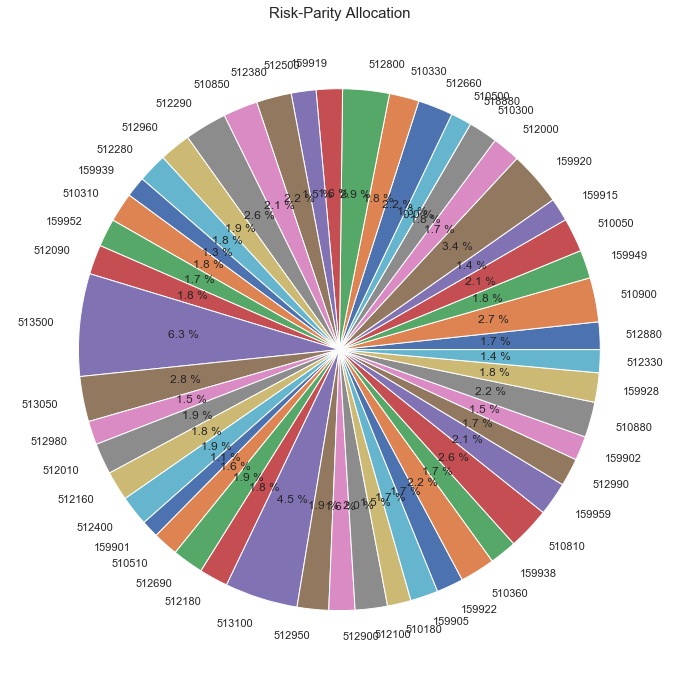

In [520]:
etfs = list(df_wts['ETF'])
weights = list(df_wts['Portfolio_Weight'])
# 保证圆形
plt.figure(1, figsize = (12, 12))
plt.axes(aspect=1)
plt.pie(x=weights, labels=etfs, autopct='%3.1f %%')
plt.title("Risk-Parity Allocation", fontsize = 15)
plt.show()

In [521]:
signal_df['code'] = signal_df['code'].astype(str)
signal_df['WEIGHT'] = ""

In [522]:
# match the weights of each ETF
for i, code_wts in enumerate(df_wts['ETF']):
    for j, code_signal in enumerate(signal_df['code']):
        if code_wts == code_signal:
            signal_df['WEIGHT'].values[j]=df_wts['Portfolio_Weight'].values[i]
            
# create the most recent trading date
last_date = signal_df['date'].values[0]

# get the close data for these tickers
signal_df_etfs = list(signal_df['code'].unique())
signal_df_closes = get_df_date_price_code(etf_path_to_csv, signal_df_etfs, 'date', 'close', 'code')

# filter the data by the most recent trading date
last_date_signal_df_closes = signal_df_closes[signal_df_closes['date']==last_date]

# merge with signal_df to get the closes so that target shares can be calculated later
signal_df_final = last_date_signal_df_closes.merge(signal_df, on = ['date','code'], how = 'outer')

# clean those without numbers in the WEIGHT columns
signal_df_final['WEIGHT'] = signal_df_final['WEIGHT'].apply(lambda x: 0 if x=="" else x)

# calculate target shares
account_values = 200000
signal_df_final['TARGET_SHARES'] = (signal_df_final['WEIGHT']*account_values)/signal_df_final['close']

# filter to get those with potential trading actions needed
condition_of_action = (signal_df_final['SIGNAL_ACTION_x']=="LONG")|(signal_df_final['SIGNAL_ACTION_x']=="SHORT")|\
                    (signal_df_final['SIGNAL_ACTION_y']=="LONG")|(signal_df_final['SIGNAL_ACTION_y']=="SHORT")
df_actions = signal_df_final[condition_of_action]

Reading Assets:  159916
Reading Assets:  159933
Reading Assets:  159951
Reading Assets:  510090
Reading Assets:  510110
Reading Assets:  510270
Reading Assets:  510580
Reading Assets:  518880
Reading Assets:  513500
Reading Assets:  513100
Reading Assets:  159920
Reading Assets:  510500
Reading Assets:  513050
Reading Assets:  510180
Reading Assets:  510900
Reading Assets:  159901
Reading Assets:  512290
Reading Assets:  512010
Reading Assets:  159928
Reading Assets:  512660
Reading Assets:  512800
Reading Assets:  512400
Reading Assets:  159919
Reading Assets:  512690
Reading Assets:  510050
Reading Assets:  159939
Reading Assets:  159938
Reading Assets:  159915
Reading Assets:  159905
Reading Assets:  510880
Reading Assets:  512330
Reading Assets:  512000
Reading Assets:  512880
Reading Assets:  512900
Reading Assets:  159922
Reading Assets:  159902
Reading Assets:  510810
Reading Assets:  159949
Reading Assets:  510510
Reading Assets:  512100
Reading Assets:  510330
Reading Assets: 

## [Save] signal_df and df_action data

In [523]:
signal_df_final.to_csv("signal_df_final.csv", mode='a', header=False)

In [524]:
df_actions.to_csv("df_actions.csv", mode='a', header=False)

In [525]:
df_actions

,date,close,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y,WEIGHT,TARGET_SHARES
13,2020-02-28,3.323,510180,NaN,NaN,NaN,空头状态,SHORT,TARGET,0.014637,880.961448
21,2020-02-28,0.705,512400,NaN,NaN,NaN,空头状态,SHORT,TARGET,0.018598,5276.136669
24,2020-02-28,2.814,510050,NaN,NaN,NaN,空头状态,SHORT,TARGET,0.021007,1493.010249
25,2020-02-28,1.354,159939,NaN,NaN,NaN,空头状态,SHORT,TARGET,0.012731,1880.499655
27,2020-02-28,1.995,159915,NaN,NaN,NaN,空头状态,SHORT,TARGET,0.014384,1441.969592
30,2020-02-28,1.139,512330,NaN,NaN,NaN,空头状态,SHORT,TARGET,0.014200,2493.403212
35,2020-02-28,3.543,159902,NaN,NaN,NaN,空头状态,SHORT,TARGET,0.014964,844.717648
37,2020-02-28,0.768,159949,NaN,NaN,NaN,空头状态,SHORT,TARGET,0.017523,4563.270268
42,2020-02-28,0.893,512980,NaN,NaN,NaN,空头状态,SHORT,TARGET,0.014691,3290.153261
44,2020-02-28,1.197,159952,NaN,NaN,NaN,空头状态,SHORT,TARGET,0.017372,2902.603239


# Live Risk Monitor

## Position Concentration Risk - Correlation Monitor

In [526]:
cur_pos_returns = get_df_date_price_code_returns(etf_path_to_csv, cur_positions, 'date', 'close', 'code')
# cur_pos_cum_returns = get_df_date_price_code_cumreturns(etf_path_to_csv, cur_positions, 'date', 'close', 'code')
cur_pos_merged_returns = merge_df_for_corr(cur_pos_returns, "date")
# cur_pos_merged_cumreturns = merge_df_for_corr(cur_pos_merged_returns, "date")

# merged_cumreturns.plot(figsize = (25, 20))
# plt.title("Cumulative Returns on 50 ETFs", fontsize = 15)

Reading Assets:  159916
Reading Assets:  159933
Reading Assets:  159951
Reading Assets:  510090
Reading Assets:  510110
Reading Assets:  510270
Reading Assets:  510580
Reading Assets:  518880


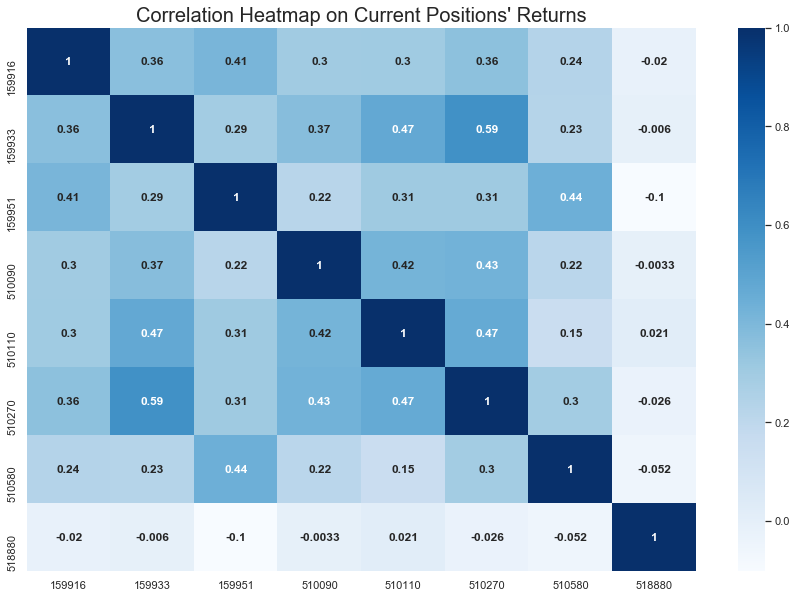

In [527]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)
ax = sns.heatmap(cur_pos_merged_returns.corr(),\
                annot=True, annot_kws={'size':12, 'weight': 'bold'}, cmap = 'Blues')
plt.title("Correlation Heatmap on Current Positions' Returns", fontsize = 20);

In [528]:
tgt_positions = list(signal_df[signal_df['TYPE_y']=="TARGET"]['code'])

In [529]:
# target_position-wise:
tgt_pos_returns = get_df_date_price_code_returns(etf_path_to_csv, tgt_positions, 'date', 'close', 'code')
# cur_pos_cum_returns = get_df_date_price_code_cumreturns(etf_path_to_csv, cur_positions, 'date', 'close', 'code')
tgt_pos_merged_returns = merge_df_for_corr(tgt_pos_returns, "date")

Reading Assets:  518880
Reading Assets:  513500
Reading Assets:  513100
Reading Assets:  159920
Reading Assets:  510500
Reading Assets:  513050
Reading Assets:  510180
Reading Assets:  510900
Reading Assets:  159901
Reading Assets:  512290
Reading Assets:  512010
Reading Assets:  159928
Reading Assets:  512660
Reading Assets:  512800
Reading Assets:  512400
Reading Assets:  159919
Reading Assets:  512690
Reading Assets:  510050
Reading Assets:  159939
Reading Assets:  159938
Reading Assets:  159915
Reading Assets:  159905
Reading Assets:  510880
Reading Assets:  512330
Reading Assets:  512000
Reading Assets:  512880
Reading Assets:  512900
Reading Assets:  159922
Reading Assets:  159902
Reading Assets:  510810
Reading Assets:  159949
Reading Assets:  510510
Reading Assets:  512100
Reading Assets:  510330
Reading Assets:  510300
Reading Assets:  512980
Reading Assets:  510310
Reading Assets:  159952
Reading Assets:  512500
Reading Assets:  512990


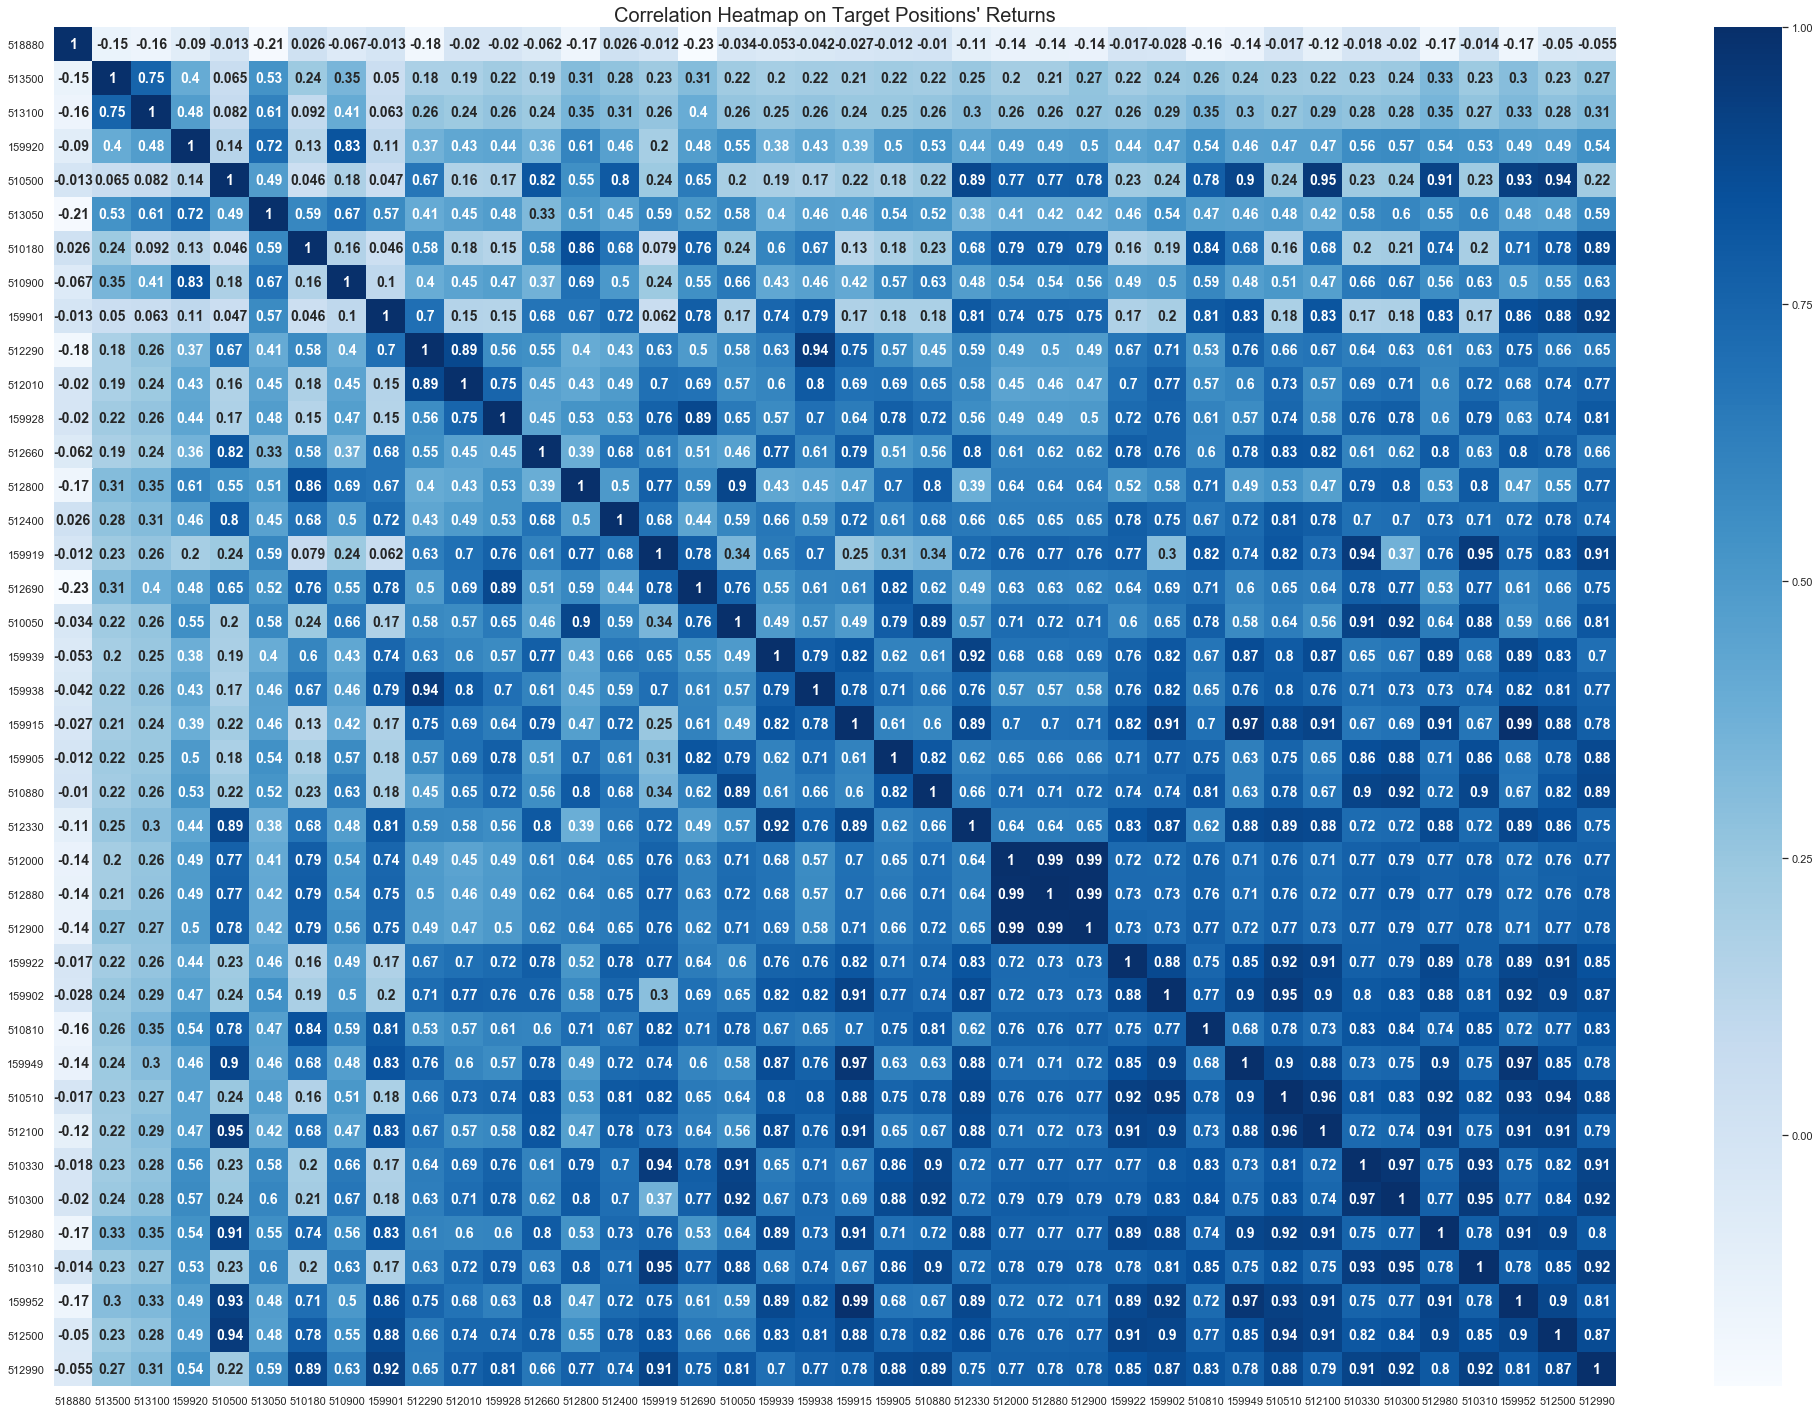

In [530]:
# corr heatmap of the target positions:
fig = plt.figure(figsize = (35, 25))
ax = fig.add_subplot(111)
ax = sns.heatmap(tgt_pos_merged_returns.corr(),\
                annot=True, annot_kws={'size':14, 'weight': 'bold'}, cmap = 'Blues')
plt.title("Correlation Heatmap on Target Positions' Returns", fontsize = 20);

In [531]:
signal_df

,date,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y,WEIGHT
0,2020-02-28,159916,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
1,2020-02-28,159933,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
2,2020-02-28,159951,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
3,2020-02-28,510090,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
4,2020-02-28,510110,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
5,2020-02-28,510270,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
6,2020-02-28,510580,多头状态,NO CHANGE,CUR_POS,NaN,NaN,NaN,
7,2020-02-28,518880,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET,0
8,2020-02-28,513500,NaN,NaN,NaN,空头状态,NO CHANGE,TARGET,0.0634712
9,2020-02-28,513100,NaN,NaN,NaN,空头状态,NO CHANGE,TARGET,0.0451865


# Calculate position concentration risk - Position-wise correlations

In [532]:
# position-wise correlation:
# forward-fill all NaNs in the df of daily returns
cur_pos_merged_returns.fillna(method='ffill', inplace=True)
a = cur_pos_merged_returns.copy()

In [533]:
# Eliminate self-correlated data with correlations of 1. For now the rolling parameter is set to be 21 days
a_ = a.rolling(21).corr()[a.rolling(21).corr()<0.999999999]
a_.reset_index(inplace = True)
a_['date'] = a_['date'].astype(str)
del a_['level_1']
a__ = a_.groupby(['date']).apply(lambda x: x.mean().mean())
pos_21_rolling_corr = pd.DataFrame(a__, columns=['pos_corr']).tail(1)

## [Save] daily rolling position correlation data

In [534]:
pos_21_rolling_corr

,pos_corr
date,
2020-02-28,0.464962


In [535]:
# pos_21_rolling_corr.to_csv("position_21_rolling_correlation.csv")
pos_21_rolling_corr.to_csv("position_21_rolling_correlation.csv", mode='a', header=False)

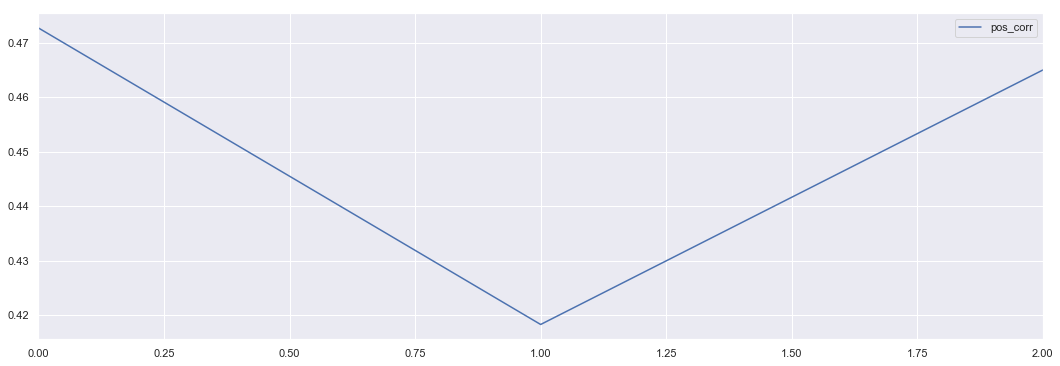

In [536]:
# Check what rolling position correlation has been changing
pos_21_rolling_corr_summary = pd.read_csv("position_21_rolling_correlation.csv")
pos_21_rolling_corr_summary.plot(figsize = (18,6))

In [537]:
# show the numbers:
pos_21_rolling_corr_summary

,date,pos_corr
0,2020-02-26,0.472670
1,2020-02-27,0.418308
2,2020-02-28,0.464962


In [538]:
# assuming we already have SH index data updated and inplace
# Correlation to the SH index:
sh_index = pd.read_csv(etf_path_to_csv+"sh000001.csv")

In [539]:
sh_index['pct_chg'] = sh_index['close'].pct_change()
sh_index.dropna(inplace=True)
sh_index_index_date = sh_index.copy()
sh_index_index_date.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'ts_code', 'pct_chg']
sh_index_index_date = sh_index_index_date[['date','pct_chg']]
sh_index_index_date.columns = ['date','sh_index']

In [540]:
cur_pos_merged_returns_with_sh = cur_pos_merged_returns.copy()
cur_pos_merged_returns_with_sh.reset_index(inplace = True)
cur_pos_merged_returns_with_sh['date'] = cur_pos_merged_returns_with_sh['date'].astype(str)
cur_pos_merged_returns_with_sh = cur_pos_merged_returns_with_sh.merge(sh_index_index_date, on = 'date')

In [541]:
corrs_cur_pos_with_sh_index = []
sh_index_pct_series = cur_pos_merged_returns_with_sh['sh_index']
for code in cur_positions:
    pct_series = cur_pos_merged_returns_with_sh[code]
    corr_with_sh_index = pct_series.corr(sh_index_pct_series)
    corrs_cur_pos_with_sh_index.append(corr_with_sh_index)

In [542]:
cur_pos_merged_returns_with_sh.index = pd.to_datetime(cur_pos_merged_returns_with_sh['date'])

In [543]:
cur_pos_merged_returns_with_sh.dropna(inplace = True)

In [544]:
# calculate rolling correlations
rolling_corrs_cur_pos_with_sh_index = []
sh_index_pct_series = cur_pos_merged_returns_with_sh['sh_index']
for code in cur_positions:
    pct_series = cur_pos_merged_returns_with_sh[code]
    rolling_corr_with_sh_index = pct_series.rolling(21).corr(sh_index_pct_series)
    rolling_corrs_cur_pos_with_sh_index.append(rolling_corr_with_sh_index)

In [545]:
rolling_corrs_cur_pos_sh_index_df = pd.concat(rolling_corrs_cur_pos_with_sh_index, axis=1)
rolling_corrs_cur_pos_sh_index_df.columns = cur_positions

In [546]:
rolling_corrs_cur_pos_sh_index_df

,159916,159933,159951,510090,510110,510270,510580,518880
date,,,,,,,,
2017-07-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-02-24,0.937272,0.781285,0.827900,0.703876,0.766212,0.901969,0.969841,-0.644144
2020-02-25,0.937503,0.784111,0.828516,0.707451,0.766903,0.901988,0.970039,-0.528555
2020-02-26,0.935773,0.792062,0.835427,0.710405,0.733844,0.898909,0.959029,-0.527229


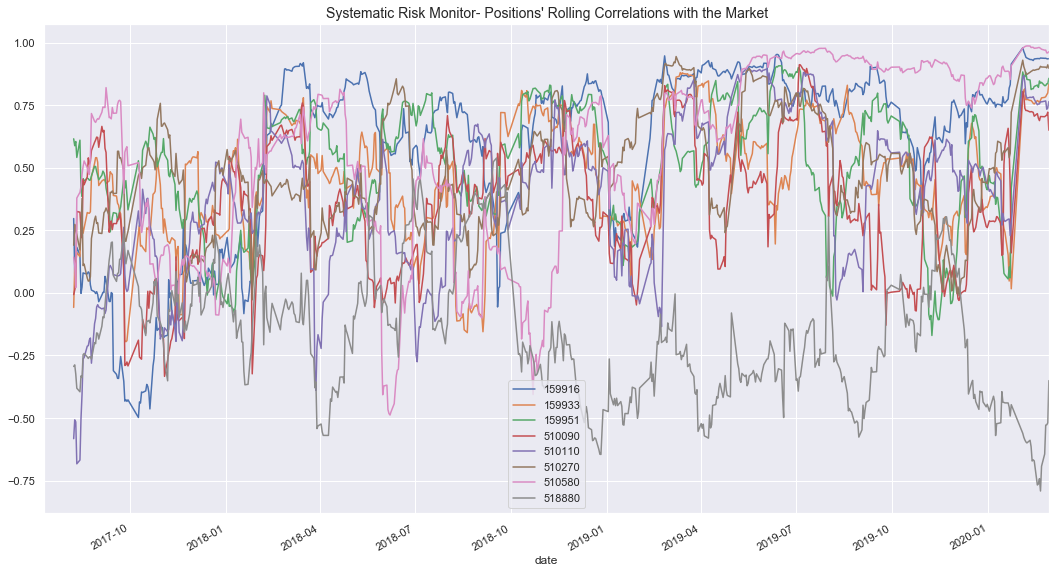

In [547]:
rolling_corrs_cur_pos_sh_index_df.plot(figsize = (18,10))
plt.title("Systematic Risk Monitor- Positions' Rolling Correlations with the Market", fontsize = 14);

In [548]:
rolling_corrs_cur_pos_sh_index_df

,159916,159933,159951,510090,510110,510270,510580,518880
date,,,,,,,,
2017-07-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-02-24,0.937272,0.781285,0.827900,0.703876,0.766212,0.901969,0.969841,-0.644144
2020-02-25,0.937503,0.784111,0.828516,0.707451,0.766903,0.901988,0.970039,-0.528555
2020-02-26,0.935773,0.792062,0.835427,0.710405,0.733844,0.898909,0.959029,-0.527229


# Performance Tracking

In [549]:
sh_index = pd.read_csv(etf_path_to_csv+"sh000001.csv")
sh_index['pct_chg'] = sh_index['close'].pct_change()
sh_index_2020 = sh_index[sh_index['trade_date']>='2020-01-02']
sh_index_2020['adjusted_pct_chg'] = sh_index_2020['pct_chg']
sh_index_2020['adjusted_pct_chg'].values[0] = 0
sh_index_2020['cum_sum_pct_chg'] = sh_index_2020['adjusted_pct_chg'].cumsum()+1

track_record = pd.DataFrame()
track_record['date'] = date
track_record['sbtv1'] = sbtv1
track_record['sh_mkt'] = sh_index_2020['cum_sum_pct_chg'].values
track_record.index = pd.to_datetime(track_record['date'])
del track_record['date']

track_record['returns0'] = track_record['sbtv1'].diff()
track_record['returns0'].values[0] = 0
track_record['returns1'] = track_record['sh_mkt'].diff()
track_record['returns1'].values[0] = 0

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [550]:
def create_sharpe_ratio(returns, periods=252):
    print("*****performance.py: 1. create_sharpe_ratio*****")
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).
    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)

def create_drawdowns(pnl):
    print("*****performance.py: 2. create_drawdowns*****")
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.
    Parameters:
    pnl - A pandas Series representing period percentage returns.
    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    hwm = [0]

    # Create the drawdown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)

    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]= (hwm[t]-pnl[t])
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()

def create_expected_annual_returns(pnl, periods=252):
    traded_days = len(pnl)
    last_pnl = pnl.values[-1]
    annual_returns = (1+last_pnl)**(periods/traded_days)-1
    return annual_returns

def create_total_returns(pnl):
    return pnl.values[-1]

In [551]:
# Calculate Alpha and Beta:

import statsmodels.api as sm
from statsmodels import regression

X = track_record['returns1'].values
Y = track_record['returns0'].values

def linreg(x, y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    
    x = x[:,1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print("alpha: ", str(alpha))
print("beta: ", str(beta))

alpha:  0.00015674598453016181
beta:  0.00036290430267807774


- 计算alpha，beta

https://blog.csdn.net/CoderPai/article/details/82868280 

In [552]:
sharpe_ratio0 = create_sharpe_ratio(track_record['returns0'], periods=252)
sharpe_ratio1 = create_sharpe_ratio(track_record['returns1'], periods=252)
drawdown0, max_drawdown0, max_dd_duration0 = create_drawdowns(track_record['sbtv1'])
drawdown1, max_drawdown1, max_dd_duration1 = create_drawdowns(track_record['sh_mkt'])
annual_returns0 = create_expected_annual_returns(track_record['sbtv1']-1)
annual_returns1 = create_expected_annual_returns(track_record['sh_mkt']-1)
total_returns0 = create_total_returns(track_record['sbtv1']-1)
total_returns1 = create_total_returns(track_record['sh_mkt']-1)
corr_returns0_1 = track_record['returns0'].corr(track_record['returns1'])
# jensen_alpha = total_returns0 - corr_returns0_1*total_returns1

*****performance.py: 1. create_sharpe_ratio*****
*****performance.py: 1. create_sharpe_ratio*****
*****performance.py: 2. create_drawdowns*****
*****performance.py: 2. create_drawdowns*****


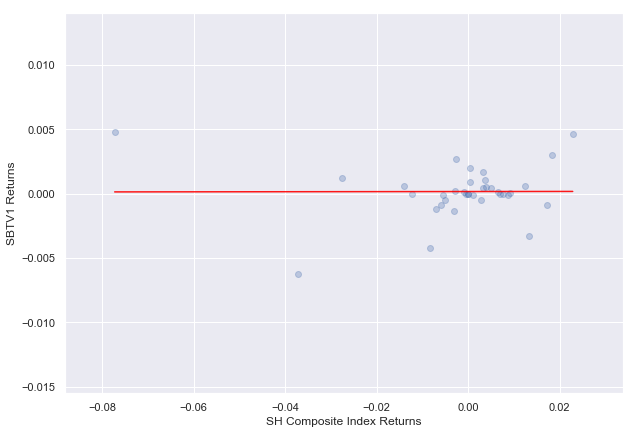

In [553]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2*beta+alpha

plt.figure(figsize=(10,7))
plt.scatter(X ,Y, alpha=0.3)
plt.xlabel("SH Composite Index Returns")
plt.ylabel("SBTV1 Returns")

plt.plot(X2, Y_hat, 'r', alpha=0.9)
plt.show()

In [554]:
last_day = sh_index['trade_date'].values[-1]

print("=========================SBTV1策略=======================")
print("\n")
print("SBTV1策略 - 开始时间：2020-01-02")
print("SBTV1策略 - 当前时间：{}".format(last_day))
print("SBTV1策略 - 实时 绝对收益：", round(total_returns0*100, 2), "%")
print("SBTV1策略 - 实时 夏普比率：", round(sharpe_ratio0, 2))
print("SBTV1策略 - 实时 期望年化收益率：", round(annual_returns0*100, 2),"%")
print("SBTV1策略 - 实时 最大回撤比率：", round(max_drawdown0*100,2), "%")
print("SBTV1策略 - 实时 最大回撤持续时间：", int(max_dd_duration0), "天")
print("SBTV1策略 - 实时 Beta：", round(beta, 4))
print("SBTV1策略 - 实时 超额收益Alpha：", round(total_returns0-total_returns1, 4))
print("SBTV1策略 - 实时 风险调整Alpha：", round(alpha, 6))
print("\n")
print("=========================上证指数=======================")
print("\n")
print("上证指数 - 开始时间：2020-01-02")
print("上证指数 - 当前时间：{}".format(last_day))
print("上证指数 - 实时 绝对收益：", round(total_returns1*100,2), "%")
print("上证指数 - 实时 夏普比率：", round(sharpe_ratio1, 2))
print("上证指数 - 实时 最大回撤比率：", round(max_drawdown1*100,2), "%")
print("上证指数 - 实时 最大回撤持续时间：", int(max_dd_duration1), "天")

=========================SBTV1策略=======================


SBTV1策略 - 开始时间：2020-01-02
SBTV1策略 - 当前时间：2020-02-28
SBTV1策略 - 实时 绝对收益： 0.56 %
SBTV1策略 - 实时 夏普比率： 1.24
SBTV1策略 - 实时 期望年化收益率： 4.0 %
SBTV1策略 - 实时 最大回撤比率： 1.15 %
SBTV1策略 - 实时 最大回撤持续时间： 9 天
SBTV1策略 - 实时 Beta： 0.0004
SBTV1策略 - 实时 超额收益Alpha： 0.0689
SBTV1策略 - 实时 风险调整Alpha： 0.000157


=========================上证指数=======================


上证指数 - 开始时间：2020-01-02
上证指数 - 当前时间：2020-02-28
上证指数 - 实时 绝对收益： -6.33 %
上证指数 - 实时 夏普比率： -1.64
上证指数 - 实时 最大回撤比率： 12.24 %
上证指数 - 实时 最大回撤持续时间： 28 天


In [555]:
my_strat_plot = go.Scatter(
    x = track_record.index,
    y = track_record['sbtv1'],
    name = 'SBTV1策略累计收益率'
)
 
    
mkt_plot = go.Scatter(
    x = track_record.index,
    y = track_record['sh_mkt'],
    name = '上证指数累积收益率'
)
    
layout = dict(title = 'SBTV1策略累计收益率',
              xaxis = dict(title = '时间'), # 横轴坐标
              yaxis = dict(title = '收益率'), # 总轴坐标
              legend=dict(x=1.1,y=1) # 图例位置 
              )

data = [my_strat_plot, mkt_plot]

fig = dict(data=data, layout=layout)

py.iplot(fig)

# Check Details of Filtered ETFs

In [556]:
og_etf_file = pd.read_csv(etf_ticker_path)
corr_mean_df_assets['etf'] = corr_mean_df_assets['etf']+".OF"
og_etf_file.columns = ['etf', '证券简称', '投资类型(一级分类)', '投资类型(二级分类)', '基金规模\n[单位] 元',
       '机构投资者持有份额\n[报告期] 2019中报\n[单位] 份', '机构投资者持有比例\n[报告期] 2019中报\n[单位] %',
       '管理费率\n[单位] %', '托管费率\n[单位] %', '认购费率\n[收费类型] 前端']
corr_mean_df_assets_info = corr_mean_df_assets.merge(og_etf_file, on = 'etf')

In [557]:
corr_mean_df_assets_info.to_csv("filtered_50_etfs_by_vol_20200224.csv")

# Calculate Market Slippage and Impact

In [558]:
vol_filtered_df

,date,open,close,high,low,volume,code,252_vol_ewm,vol_ewm_rank
16332,2020-02-28,1.025,0.987,1.032,0.982,27670601.0,512880,8.693512e+06,1.0
18120,2020-02-28,1.177,1.178,1.195,1.171,18388895.0,510900,8.570472e+06,2.0
27700,2020-02-28,0.785,0.768,0.800,0.765,23133204.0,159949,7.056419e+06,3.0
4157,2020-02-28,2.850,2.814,2.876,2.806,6958786.0,510050,5.912825e+06,4.0
14089,2020-02-28,2.041,1.995,2.074,1.985,11449502.0,159915,5.093083e+06,5.0
26824,2020-02-28,1.401,1.445,1.468,1.401,9924449.0,159920,4.991098e+06,6.0
33983,2020-02-28,0.973,0.938,0.982,0.934,13925549.0,512000,3.941801e+06,7.0
6045,2020-02-28,4.010,3.933,4.019,3.924,5600710.0,510300,3.603080e+06,8.0
19725,2020-02-28,3.652,3.623,3.660,3.605,5007922.0,518880,3.578624e+06,9.0
1690,2020-02-28,6.061,5.906,6.103,5.898,5454975.0,510500,2.298998e+06,10.0


# 给ETF分类

In [696]:
sectors = {
        "A股大盘":["中证500","上证180","沪深300","深证100","中证800","中证100",
                "上证50","全指","沪深300非银","上证龙头","A50","上证综指","上证380","大盘","深证300"],
        "政府债":["政府债","城投债","国债",],
        "公司债":["信用债","公司债"],
        "黄金":["黄金"],
        "人工智能":["人工智能"],
        "美股":["标普","纳指","纳斯达克",],
        "创业板":["创业板","中创400"],
        "港股":["H股","恒生","港股",],
        "科技":["科技龙头","科技"],
        "军工与国防":["军工","国防"],
        "一带一路":["一带一路"],
        "消费":["消费"],
        "医药卫生":["医药卫生","医药","医疗"],
        "创新驱动":["创新驱动"],
        "MSCI类":["MSCI"],
        "红利":["红利"],
        "基本面":["基本面"],
        "信息技术":["信息技术","计算机"],
        "地产":["地产"],
        "通信":["通信"],
        "价值":["价值","蓝筹"],
        "能源":["能源","资源"],
        "结构调整":["结构调整","国改","治理"],
        "国企":["国企","央企"],
        "金融":["证券","银行"],
        "区域发展":["粤港澳大湾区","长三角一体化发展","杭州湾区","京津冀","北京50"],
        "中小板":["中小板","中小盘"],
        "德国":["德国"],
        "日本":["日经225"],
        "半导体":["半导体"],
        "商品":["有色金属","豆粕","商品"],
        "社会责任":["社会责任","环保","可持续发展"],
        "周期":["周期"],
        "工业":["工业"],
        "中关村":["中关村"],
        "成长":["成长"],
        "研发创新":["研发创新"],
        "民营民企":["民营","民企"],
        "高股息":["高股息"],
        }

In [697]:
etf_sectors = pd.read_csv("/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/ETF基金（非货币）-快照1.csv")

In [698]:
etf_sectors.head(5)

,证券代码,证券简称,投资类型(一级分类),投资类型(二级分类),基金规模\n[单位] 元,机构投资者持有份额\n[报告期] 2019中报\n[单位] 份,机构投资者持有比例\n[报告期] 2019中报\n[单位] %,管理费率\n[单位] %,托管费率\n[单位] %,认购费率\n[收费类型] 前端
0,510500.OF,南方中证500ETF,股票型基金,被动指数型基金,"43,495,546,173.14","6,869,516,878.00",76.03,0.5,0.1,500万份以上 1000元/笔\n100万份以下 1%\n100~300万份 0.6%\n3...
1,510050.OF,华夏上证50ETF,股票型基金,被动指数型基金,"41,661,539,684.86","12,207,777,650.00",73.10,0.5,0.1,100万份以下 1%\n100~1000万份 0.8%\n1000万份以上 0.5%\n
2,510300.OF,华泰柏瑞沪深300ETF,股票型基金,被动指数型基金,"34,511,958,155.73","6,917,063,977.00",73.10,0.5,0.1,100万份以上 1000元/笔\n50万份以下 1%\n50~100万份 0.5%\n
3,510330.OF,华夏沪深300ETF,股票型基金,被动指数型基金,"27,011,633,280.07","6,727,655,374.00",96.86,0.5,0.1,100万份以上 1000元/笔\n50万份以下 0.8%\n50~100万份 0.5%\n
4,159919.OF,嘉实沪深300ETF,股票型基金,被动指数型基金,"22,648,809,377.90","6,276,554,937.00",92.26,0.5,0.1,100万份以上 1000元/笔\n50万份以下 1%\n50~100万份 0.5%\n


In [699]:
etf_sectors['所属板块'] = ""

In [700]:
for k, v in sectors.items():
    for i, item in enumerate(etf_sectors['证券简称']):
        print(item)
        for v_ in v:
            if v_ in item:
                print(v_)
                etf_sectors['所属板块'][i] = k

南方中证500ETF
华夏上证50ETF
华泰柏瑞沪深300ETF
华夏沪深300ETF
嘉实沪深300ETF
华安上证180ETF
易方达创业板ETF
博时央企结构调整ETF
博时央企创新驱动ETF
华夏央企结构调整ETF
汇添富中证上海国企ETF
嘉实中证央企创新驱动ETF
海富通上证5年期地方政府债ETF
国泰中证全指证券公司ETF
易方达恒生H股ETF
华安黄金ETF
易方达沪深300ETF
易方达中证国企一带一路ETF
富国中证国企一带一路ETF
广发中证央企创新驱动ETF
易方达深证100ETF
华宝中证科技龙头ETF
华夏中证500ETF
汇添富中证800ETF
汇添富中证长三角一体化发展ETF
平安粤港澳大湾区ETF
华夏恒生ETF
富国中证军工龙头ETF
华安创业板50ETF
国泰上证180金融ETF
工银上证50ETF
银华央企结构调整ETF
平安中债-中高等级公司债利差因子ETF
平安沪深300ETF
博时黄金ETF
广发中证500ETF
国寿安保沪深300ETF
鹏华中证5年期地方政府债ETF
华夏中证5G通信主题ETF
华宝中证全指证券ETF
工银沪深300ETF
华夏中证四川国改ETF
汇添富中证国企一带一路ETF
广发沪深300ETF
汇添富中证主要消费ETF
嘉实中证500ETF
华泰柏瑞红利ETF
博时中证500ETF
广发中证全指医药卫生ETF
平安中证500ETF
华夏中小板ETF
富国中证科技50策略ETF
华泰柏瑞中证科技100ETF
易方达黄金ETF
国泰中证军工ETF
易方达沪深300非银ETF
广发中证全指信息技术ETF
海富通上证城投债ETF
南方中证全指证券公司ETF
富国中证央企创新驱动ETF
银华MSCI中国A股ETF
华宝中证银行ETF
广发中证环保产业ETF
南方沪深300ETF
工银瑞信深证红利ETF
兴业上证红利低波动ETF
国泰CES半导体ETF
广发创业板ETF
嘉实深证基本面120ETF
基本面
建信沪深300红利ETF
嘉实中证新兴科技100策略ETF
海富通上证10年期地方政府债ETF
工银瑞信粤港澳大湾区创新100ETF
易方达中证海外互联ETF
南方创业板ETF
广发中证传媒ETF
平安5-10年期国债活跃券ETF
博时标普500ETF
工银瑞信中证500ETF
嘉实中证锐联基本面50ET

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




华安黄金ETF
易方达沪深300ETF
易方达中证国企一带一路ETF
富国中证国企一带一路ETF
广发中证央企创新驱动ETF
易方达深证100ETF
华宝中证科技龙头ETF
华夏中证500ETF
汇添富中证800ETF
汇添富中证长三角一体化发展ETF
平安粤港澳大湾区ETF
华夏恒生ETF
富国中证军工龙头ETF
华安创业板50ETF
国泰上证180金融ETF
工银上证50ETF
银华央企结构调整ETF
平安中债-中高等级公司债利差因子ETF
平安沪深300ETF
博时黄金ETF
广发中证500ETF
国寿安保沪深300ETF
鹏华中证5年期地方政府债ETF
华夏中证5G通信主题ETF
华宝中证全指证券ETF
工银沪深300ETF
华夏中证四川国改ETF
汇添富中证国企一带一路ETF
广发沪深300ETF
汇添富中证主要消费ETF
嘉实中证500ETF
华泰柏瑞红利ETF
博时中证500ETF
广发中证全指医药卫生ETF
平安中证500ETF
华夏中小板ETF
富国中证科技50策略ETF
华泰柏瑞中证科技100ETF
易方达黄金ETF
国泰中证军工ETF
易方达沪深300非银ETF
广发中证全指信息技术ETF
海富通上证城投债ETF
南方中证全指证券公司ETF
富国中证央企创新驱动ETF
银华MSCI中国A股ETF
华宝中证银行ETF
广发中证环保产业ETF
南方沪深300ETF
工银瑞信深证红利ETF
兴业上证红利低波动ETF
国泰CES半导体ETF
广发创业板ETF
嘉实深证基本面120ETF
建信沪深300红利ETF
嘉实中证新兴科技100策略ETF
海富通上证10年期地方政府债ETF
工银瑞信粤港澳大湾区创新100ETF
易方达中证海外互联ETF
南方创业板ETF
广发中证传媒ETF
平安5-10年期国债活跃券ETF
博时标普500ETF
工银瑞信中证500ETF
嘉实中证锐联基本面50ETF
易方达中证红利ETF
华夏中证人工智能ETF
招商深证100ETF
易方达中证500ETF
申万菱信中证研发创新100ETF
富国中证消费50ETF
华夏沪港通恒生ETF
南方中证500信息技术ETF
易方达沪深300医药卫生ETF
易方达中证800ETF
嘉实沪深300红利低波动ETF
大成MSCI中国A股质优价值100ETF
前海开源中证500等权ETF
建信

国泰中证计算机ETF
招商中证红利ETF
景顺长城中证TMT150ETF
浙商汇金中证凤凰50ETF
大成有色金属期货ETF
南方中证申万有色金属ETF
景顺长城中证500ETF
广发中证全指可选消费ETF
消费
华泰柏瑞红利低波动ETF
汇添富沪深300ETF
嘉实先进制造100ETF
华夏创业板低波蓝筹ETF
平安中证人工智能ETF
招商深证TMT50ETF
华夏饲料豆粕期货ETF
富国上证综指ETF
华夏战略新兴成指ETF
南方中证银行ETF
工银瑞信创业板ETF
中融央视财经50ETF
易方达上证中盘ETF
新华MSCI中国A股国际ETF
大成深证成份ETF
天弘沪深300ETF
华夏上证主要消费ETF
消费
招商上证消费80ETF
消费
中融中证500ETF
华安中证500行业中性低波动ETF
华夏中证全指房地产ETF
平安MSCI中国A股低波动ETF
方正富邦沪深300ETF
汇添富中证银行ETF
广发中小板300ETF
平安MSCI中国A股国际ETF
南方上证380ETF
南方中证1000ETF
博时超大盘ETF
华夏创业板ETF
汇安富时中国A50ETF
嘉实富时中国A50ETF
华宝上证180价值ETF
方正富邦中证500ETF
万家上证50ETF
工银上证央企50ETF
鹏华中证酒ETF
华泰柏瑞上证中小盘ETF
华夏创业板动量成长ETF
南方恒生中国企业ETF
大成深证成长40ETF
嘉实中创400ETF
汇添富深证300ETF
建信上证社会责任ETF
国联安上证商品ETF
博时创业板ETF
易方达日兴资管日经225ETF
南华中证杭州湾区ETF
华安沪深300行业中性低波动ETF
华安上证龙头ETF
博时自然资源ETF
银华上证50等权重ETF
国泰上证10年期国债ETF
华安中证细分医药ETF
华夏上证医药卫生ETF
华宝中证医疗ETF
申万菱信上证50ETF
南方恒生ETF
富国恒生中国企业ETF
鹏华上证民企50ETF
交银深证300价值ETF
南方中证全指房地产ETF
广发中证京津冀ETF
建信创业板ETF
华宝中证军工ETF
华安中证民企成长ETF
南方东证指数ETF
嘉实中证金融地产ETF
平安创业板ETF
华安三菱日联日经225ETF
鹏华深证民营ETF
南方中证500工业ETF
华夏3-5年中高级可质押信用债ETF
华夏野村日

华夏中证500ETF
汇添富中证800ETF
汇添富中证长三角一体化发展ETF
平安粤港澳大湾区ETF
华夏恒生ETF
富国中证军工龙头ETF
军工
华安创业板50ETF
国泰上证180金融ETF
工银上证50ETF
银华央企结构调整ETF
平安中债-中高等级公司债利差因子ETF
平安沪深300ETF
博时黄金ETF
广发中证500ETF
国寿安保沪深300ETF
鹏华中证5年期地方政府债ETF
华夏中证5G通信主题ETF
华宝中证全指证券ETF
工银沪深300ETF
华夏中证四川国改ETF
汇添富中证国企一带一路ETF
广发沪深300ETF
汇添富中证主要消费ETF
嘉实中证500ETF
华泰柏瑞红利ETF
博时中证500ETF
广发中证全指医药卫生ETF
平安中证500ETF
华夏中小板ETF
富国中证科技50策略ETF
华泰柏瑞中证科技100ETF
易方达黄金ETF
国泰中证军工ETF
军工
易方达沪深300非银ETF
广发中证全指信息技术ETF
海富通上证城投债ETF
南方中证全指证券公司ETF
富国中证央企创新驱动ETF
银华MSCI中国A股ETF
华宝中证银行ETF
广发中证环保产业ETF
南方沪深300ETF
工银瑞信深证红利ETF
兴业上证红利低波动ETF
国泰CES半导体ETF
广发创业板ETF
嘉实深证基本面120ETF
建信沪深300红利ETF
嘉实中证新兴科技100策略ETF
海富通上证10年期地方政府债ETF
工银瑞信粤港澳大湾区创新100ETF
易方达中证海外互联ETF
南方创业板ETF
广发中证传媒ETF
平安5-10年期国债活跃券ETF
博时标普500ETF
工银瑞信中证500ETF
嘉实中证锐联基本面50ETF
易方达中证红利ETF
华夏中证人工智能ETF
招商深证100ETF
易方达中证500ETF
申万菱信中证研发创新100ETF
富国中证消费50ETF
华夏沪港通恒生ETF
南方中证500信息技术ETF
易方达沪深300医药卫生ETF
易方达中证800ETF
嘉实沪深300红利低波动ETF
大成MSCI中国A股质优价值100ETF
前海开源中证500等权ETF
建信深证基本面60ETF
南方MSCI国际通ETF
易方达上证50ETF
国寿安保中证500ETF
华泰柏瑞中证500ETF
南方粤港澳大湾区创新100ETF
国泰纳斯

广发中证传媒ETF
平安5-10年期国债活跃券ETF
博时标普500ETF
工银瑞信中证500ETF
嘉实中证锐联基本面50ETF
易方达中证红利ETF
华夏中证人工智能ETF
招商深证100ETF
易方达中证500ETF
申万菱信中证研发创新100ETF
富国中证消费50ETF
华夏沪港通恒生ETF
南方中证500信息技术ETF
易方达沪深300医药卫生ETF
易方达中证800ETF
嘉实沪深300红利低波动ETF
大成MSCI中国A股质优价值100ETF
前海开源中证500等权ETF
建信深证基本面60ETF
南方MSCI国际通ETF
易方达上证50ETF
国寿安保中证500ETF
华泰柏瑞中证500ETF
南方粤港澳大湾区创新100ETF
国泰纳斯达克100ETF
天弘创业板ETF
易方达MSCI中国A股国际通ETF
国泰黄金ETF
华夏中证全指证券公司ETF
方正富邦深证100ETF
富国中证价值ETF
华夏MSCI中国A股国际通ETF
南方小康产业ETF
博时上证50ETF
银华巨潮小盘价值ETF
建信MSCI中国A股国际通ETF
国联安沪深300ETF
平安港股通恒生中国企业ETF
华安德国30(DAX)ETF
德国
国泰上证5年期国债ETF
鹏华中证500ETF
建信易盛郑商所能源化工期货ETF
广发中证全指金融地产ETF
国泰中证全指通信设备ETF
广发中证军工ETF
鹏华中证国防ETF
广发中证100ETF
华泰柏瑞MSCI中国A股国际通ETF
银华中证研发创新100ETF
华安沪深300ETF
景顺长城MSCI中国A股国际通ETF
国联安中证全指半导体ETF
银华深证100ETF
弘毅远方国证民企领先100ETF
南方深成ETF
国泰中证生物医药ETF
国投瑞银沪深300金融地产ETF
建信上证50ETF
交银180治理ETF
汇添富中证医药卫生ETF
华夏中证银行ETF
国泰中证计算机ETF
招商中证红利ETF
景顺长城中证TMT150ETF
浙商汇金中证凤凰50ETF
大成有色金属期货ETF
南方中证申万有色金属ETF
景顺长城中证500ETF
广发中证全指可选消费ETF
华泰柏瑞红利低波动ETF
汇添富沪深300ETF
嘉实先进制造100ETF
华夏创业板低波蓝筹ETF
平安中证人工智能ETF
招商深证TMT50ETF
华夏饲料豆粕期货ET

银华上证50等权重ETF
国泰上证10年期国债ETF
国债
华安中证细分医药ETF
华夏上证医药卫生ETF
华宝中证医疗ETF
申万菱信上证50ETF
南方恒生ETF
富国恒生中国企业ETF
鹏华上证民企50ETF
交银深证300价值ETF
南方中证全指房地产ETF
广发中证京津冀ETF
建信创业板ETF
华宝中证军工ETF
华安中证民企成长ETF
南方东证指数ETF
嘉实中证金融地产ETF
平安创业板ETF
华安三菱日联日经225ETF
鹏华深证民营ETF
南方中证500工业ETF
华夏3-5年中高级可质押信用债ETF
华夏野村日经225ETF
南方中证500医药卫生ETF
华安CES港股通精选100ETF
南方中证500原材料ETF
华夏上证金融地产ETF
富国中证10年期国债ETF
国债
海富通上证周期ETF
华安MSCI中国A股国际ETF
大成中证500沪市ETF
大成中证100ETF
汇添富中证金融地产ETF
大成中证500深市ETF
广发中证全指能源ETF
广发上证10年期国债ETF
国债
嘉实创业板ETF
中信建投北京50ETF
易方达中证全指证券公司ETF
易方达中证军工ETF
海富通上证非周期ETF
浦银安盛中证高股息ETF
广发中证全指原材料ETF
广发中证全指工业ETF
广发纳斯达克100ETF
汇添富中证能源ETF
嘉实中证主要消费ETF
中银上证国企ETF
嘉实中证医药卫生ETF
嘉实中关村A股ETF
富国创业板ETF
嘉实中证中期国债ETF
国债
建信港股通恒生中国企业ETF
华富中证人工智能产业ETF
富国中证全指证券公司ETF
平安中证新能源汽车产业ETF
泰康沪深300ETF
民生加银沪深300ETF
招商MSCI中国A股国际通ETF
博时可持续发展100ETF
汇添富中国战略新兴产业ETF
鹏华中证银行ETF
鹏华国证证券龙头ETF
弘毅远方国证消费100ETF
广发粤港澳大湾区创新100ETF
工银瑞信深证100ETF


In [701]:
etf_sectors.to_csv("/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/ETF_板块已分类.csv", index=False)

In [702]:
etf_sectors = pd.read_csv("/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/ETF_板块已分类.csv")

etf_sectors.dropna(inplace=True)
filtered_1 = etf_sectors[etf_sectors['所属板块']!=""]
filtered_1.columns = ['ticker','name','type1','type2','mkt_cap','institution_holdings',
                      'ins_holding_pct','fee1%','fee2%','fee3%','sector']
filtered_1['mkt_cap'] = filtered_1['mkt_cap'].apply(lambda x: x.replace(",","")).apply(lambda x: float(x))
filtered_1.reset_index(inplace = True)
del filtered_1['index']

In [703]:
filtered_1['rank'] = filtered_1.groupby(['sector'])['mkt_cap'].rank()
filtered_2 = filtered_1[filtered_1['rank']==1]

In [704]:
filtered_2['code'] = filtered_2['ticker'].str.split(".", expand = True)[0]
filtered_2['exchange'] = filtered_2['ticker'].str.split(".", expand = True)[1]

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [705]:
filtered_2_tickers = list(filtered_2['code'].unique())

In [706]:
filtered_2_tickers

['518880',
 '159916',
 '512040',
 '513030',
 '510010',
 '512890',
 '512820',
 '510220',
 '159906',
 '510090',
 '510170',
 '159911',
 '511280',
 '512860',
 '159931',
 '159955',
 '512850',
 '512560',
 '510120',
 '512590',
 '159953',
 '159941',
 '159930',
 '512600',
 '510270',
 '512610',
 '159951',
 '159926',
 '513680']

In [707]:
len(filtered_2_tickers)

29

In [708]:
# target_position-wise:
tgt_pos_returns2 = get_df_date_price_code_returns(etf_path_to_csv, filtered_2_tickers, 'date', 'close', 'code')
# cur_pos_cum_returns = get_df_date_price_code_cumreturns(etf_path_to_csv, cur_positions, 'date', 'close', 'code')
tgt_pos_merged_returns2 = merge_df_for_corr(tgt_pos_returns2, "date")

Reading Assets:  518880
Reading Assets:  159916
Reading Assets:  512040
Reading Assets:  513030
Reading Assets:  510010
Reading Assets:  512890
Reading Assets:  512820
Reading Assets:  510220
Reading Assets:  159906
Reading Assets:  510090
Reading Assets:  510170
Reading Assets:  159911
Reading Assets:  511280
Reading Assets:  512860
Reading Assets:  159931
Reading Assets:  159955
Reading Assets:  512850
Reading Assets:  512560
Reading Assets:  510120
Reading Assets:  512590
Reading Assets:  159953
Reading Assets:  159941
Reading Assets:  159930
Reading Assets:  512600
Reading Assets:  510270
Reading Assets:  512610
Reading Assets:  159951
Reading Assets:  159926
Reading Assets:  513680


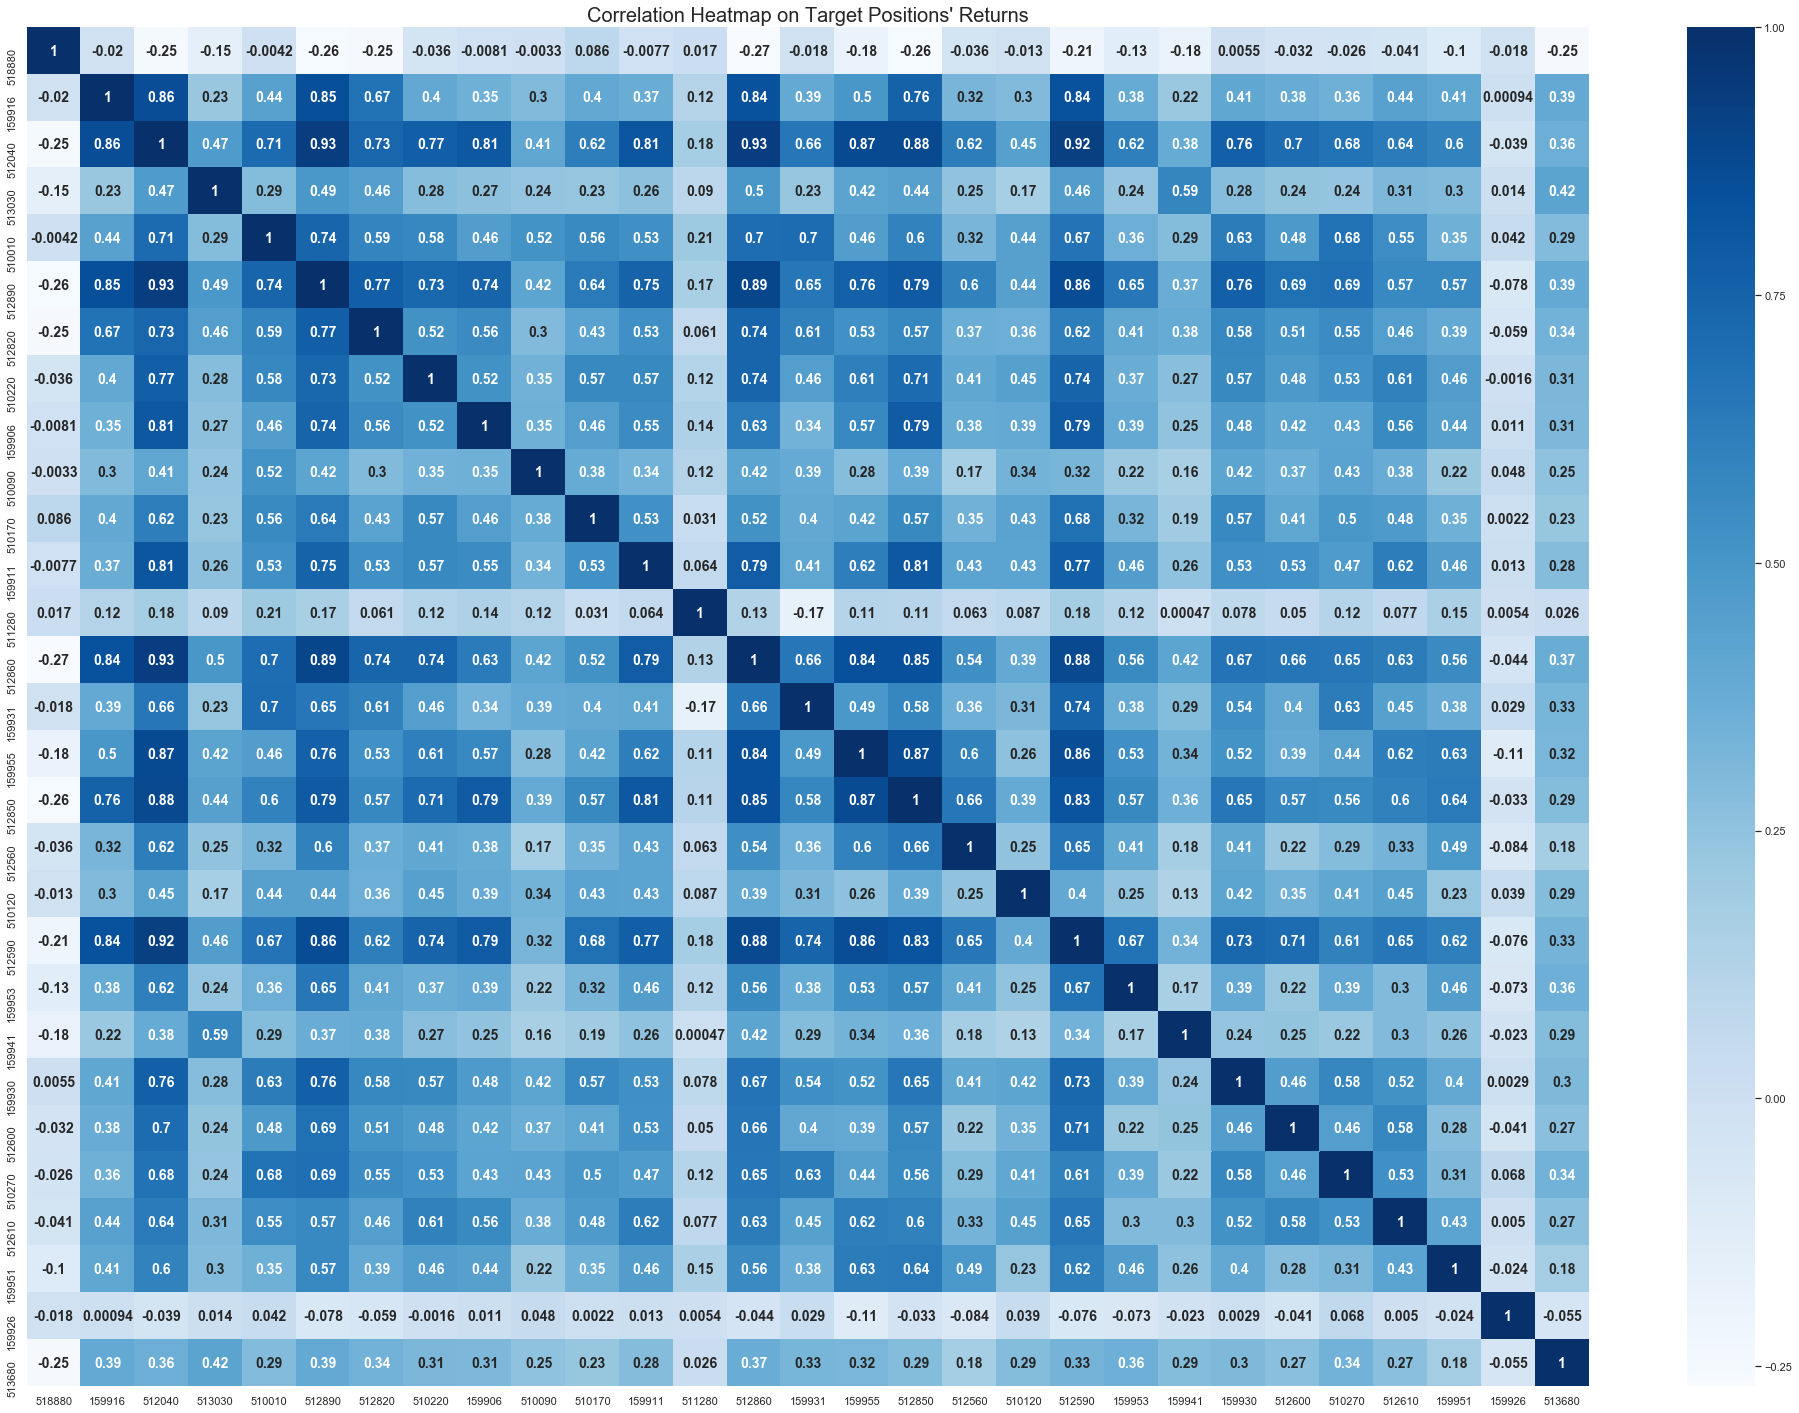

In [709]:
# corr heatmap of the target positions:
fig = plt.figure(figsize = (35, 25))
ax = fig.add_subplot(111)
ax = sns.heatmap(tgt_pos_merged_returns2.corr(),\
                annot=True, annot_kws={'size':14, 'weight': 'bold'}, cmap = 'Blues')
plt.title("Correlation Heatmap on Target Positions' Returns", fontsize = 20);

In [710]:
tgt_pos_merged_returns2.corr()[tgt_pos_merged_returns2.corr()<0.99999].mean().mean()

0.38559255626891464